In [121]:
MKT_BOOK = {}

In [1]:
import pandas as pd
import numpy as np
import os
from pylab import mpl, plt
pd.options.display.float_format = '{:,.2f}'.format

# Toy universe of some S&P 500 securities
SYM_LIST = ['GOOGL', 'FB', 'TWTR', 'VRSN', 'AKAM', 'TRIP', 'MSFT', 'ADP', 'CTXS', 'IRM', 'FFIV',
           'JPM', 'BAC', 'WFC', 'C', 'PNC', 'CMA', 'PYPL', 'MA', 'V', 'AXP', 'COF', 'DFS', 'SYF',
           'EFX', 'WU', 'NAVI', 'ORCL', 'ADBE', 'CRM', 'INTU', 'ANSS', 'CDNS',
           'WMT', 'COST', 'TGT', 'DG', 'DLTR',
           'DIS', 'CMCSA', 'FOXA']

In [123]:
# Finance data time
from datetime import datetime
from iexfinance.stocks import get_historical_data

# Get open and close prices daily for all of 2019 for securities in universe (252 rows per security)
for sym in SYM_LIST:
    if sym not in MKT_BOOK:
        start = datetime(2019, 1, 1)
        end = datetime(2019, 12, 31)
        print("Retrieving {}".format(sym))
        MKT_BOOK[sym] = pd.DataFrame(get_historical_data(sym, start, end)).transpose()
    else:
        print('{} already retrieved'.format(sym))

Retrieving GOOGL
Retrieving FB
Retrieving TWTR
Retrieving VRSN
Retrieving AKAM
Retrieving TRIP
Retrieving MSFT
Retrieving ADP
Retrieving CTXS
Retrieving IRM
Retrieving FFIV
Retrieving JPM
Retrieving BAC
Retrieving WFC
Retrieving C
Retrieving PNC
Retrieving CMA
Retrieving PYPL
Retrieving MA
Retrieving V
Retrieving AXP
Retrieving COF
Retrieving DFS
Retrieving SYF
Retrieving EFX
Retrieving WU
Retrieving NAVI
Retrieving ORCL
Retrieving ADBE
Retrieving CRM
Retrieving INTU
Retrieving ANSS
Retrieving CDNS
Retrieving WMT
Retrieving COST
Retrieving TGT
Retrieving DG
Retrieving DLTR
Retrieving DIS
Retrieving CMCSA
Retrieving FOXA


In [124]:
def pos_streaker(x):
    global count
    if(x > 0):
        count += 1
    else:
        count = 0
    return count

In [125]:
def neg_streaker(x):
    global count
    if(x <= 0):
        count += 1
    else:
        count = 0
    return count

In [126]:
def strat_builder(x):
    if x['volume'] < (x['vol_mean'] - x['vol_std']) and x['dow'] == 'Friday':
        return -1
    elif x['volume'] > (x['vol_mean'] + x['vol_std']) and x['dow'] != 'Friday':
        return 1
    else:
        return 0
    
    

In [127]:
def ten_twenty_avg(x):
    if (x['10_avg'] > x['20_avg']):
        return 1
    else:
        return -1

In [128]:
def dow_strat_builder(x):
    if x['dow'] == 'Friday': # Short on Friday Close
        return -1
    elif x['dow'] == 'Monday': # Long Monday Open
        return 1
    else:
        return 0

In [129]:
corr_frame = pd.DataFrame()

In [133]:
# Securities that show strong strong correlation between returns when shifted may be useful to predict future returns
one_per_return_corr = pd.DataFrame()
corr_list = []
for sym in MKT_BOOK:
    one_per_return_corr[sym] = MKT_BOOK[sym].shift(3)['log_returns'] # Three day shift correlation between closing prices
one_per_return_corr = one_per_return_corr.corr() 
one_per_return_corr = one_per_return_corr[one_per_return_corr > 0.8]
one_per_return_corr = one_per_return_corr[one_per_return_corr < 1]
one_per_return_corr[:5]
for col in one_per_return_corr:
    for idx, val in one_per_return_corr[col].iteritems():
        if not pd.isna(val):
            print("Three period shifted Corr between {} and {} is {}".format(col, idx, val))
            # append col and idx as tuples to pull out into a strat corr_list.append()
            

Three period shifted Corr between JPM and BAC is 0.8541726622542128
Three period shifted Corr between JPM and C is 0.8589118629398886
Three period shifted Corr between JPM and PNC is 0.8373995389593366
Three period shifted Corr between BAC and JPM is 0.8541726622542128
Three period shifted Corr between BAC and C is 0.8277529447607416
Three period shifted Corr between BAC and PNC is 0.8147069037187039
Three period shifted Corr between C and JPM is 0.8589118629398886
Three period shifted Corr between C and BAC is 0.8277529447607416
Three period shifted Corr between PNC and JPM is 0.8373995389593366
Three period shifted Corr between PNC and BAC is 0.8147069037187039
Three period shifted Corr between MA and V is 0.868699989746726
Three period shifted Corr between V and MA is 0.868699989746726


In [131]:
# TODO strat based on above
# If DFS log returns > 0 1 else -1

In [132]:
for sym in SYM_LIST:
    df = MKT_BOOK[sym]
    
    df['log_returns'] = np.log(df['close']/df['close'].shift(1))
    
    df['vol_mean'] = df['volume'].mean()
    df['vol_std']= df['volume'].std()
    day_series = pd.date_range(start, end, freq='D').to_series()
    day_series_dow = day_series.dt.dayofweek
    df['volume_direction'] = np.where(df['volume'] > df['volume'].shift(1), 1, -1)
    df['10_avg'] = df['close'].rolling(10).mean()
    df['20_avg'] = df['close'].rolling(20).mean()
    df['date'] = df.index
    count = 0 
    df['up_streaks'] = df['log_returns'].apply(pos_streaker)
    df['down_streaks'] = df['log_returns'].apply(neg_streaker)
    
    
    df['dow'] = pd.to_datetime(df['date'], errors='coerce').dt.day_name()
    
    
    df['price_mean'] = df['close'].mean()
    df['price_std'] = df['close'].std()
    df['std_dist'] = ((df['close'] - df['price_mean']) / df['price_std'])
    
    df['dist_ovr_two_sig'] = np.where(abs(df['std_dist']) > 1, 1, 0) # expand this to a a strat to apply       
    
    df['strat'] = df.apply(dow_strat_builder, axis=1) # Evaluate strategy across universe of securities
    # Shift a day forward - if a strat initiates at the close, it captures the next close-close log returns
    df['strat_returns'] = np.cumsum(df['strat'] * df.shift(-1, fill_value=0)['log_returns']) # generate strategy returns
    
    # To do return strategy from that
    df['passive_returns'] = np.cumsum(df['log_returns']) # Generate passive returns
    
    df['two_sig_returns'] = np.cumsum(df['dist_ovr_two_sig'] * df.shift(-1, fill_value=0)['log_returns'])

In [ ]:
MKT_BOOK['MSFT'][-10:]

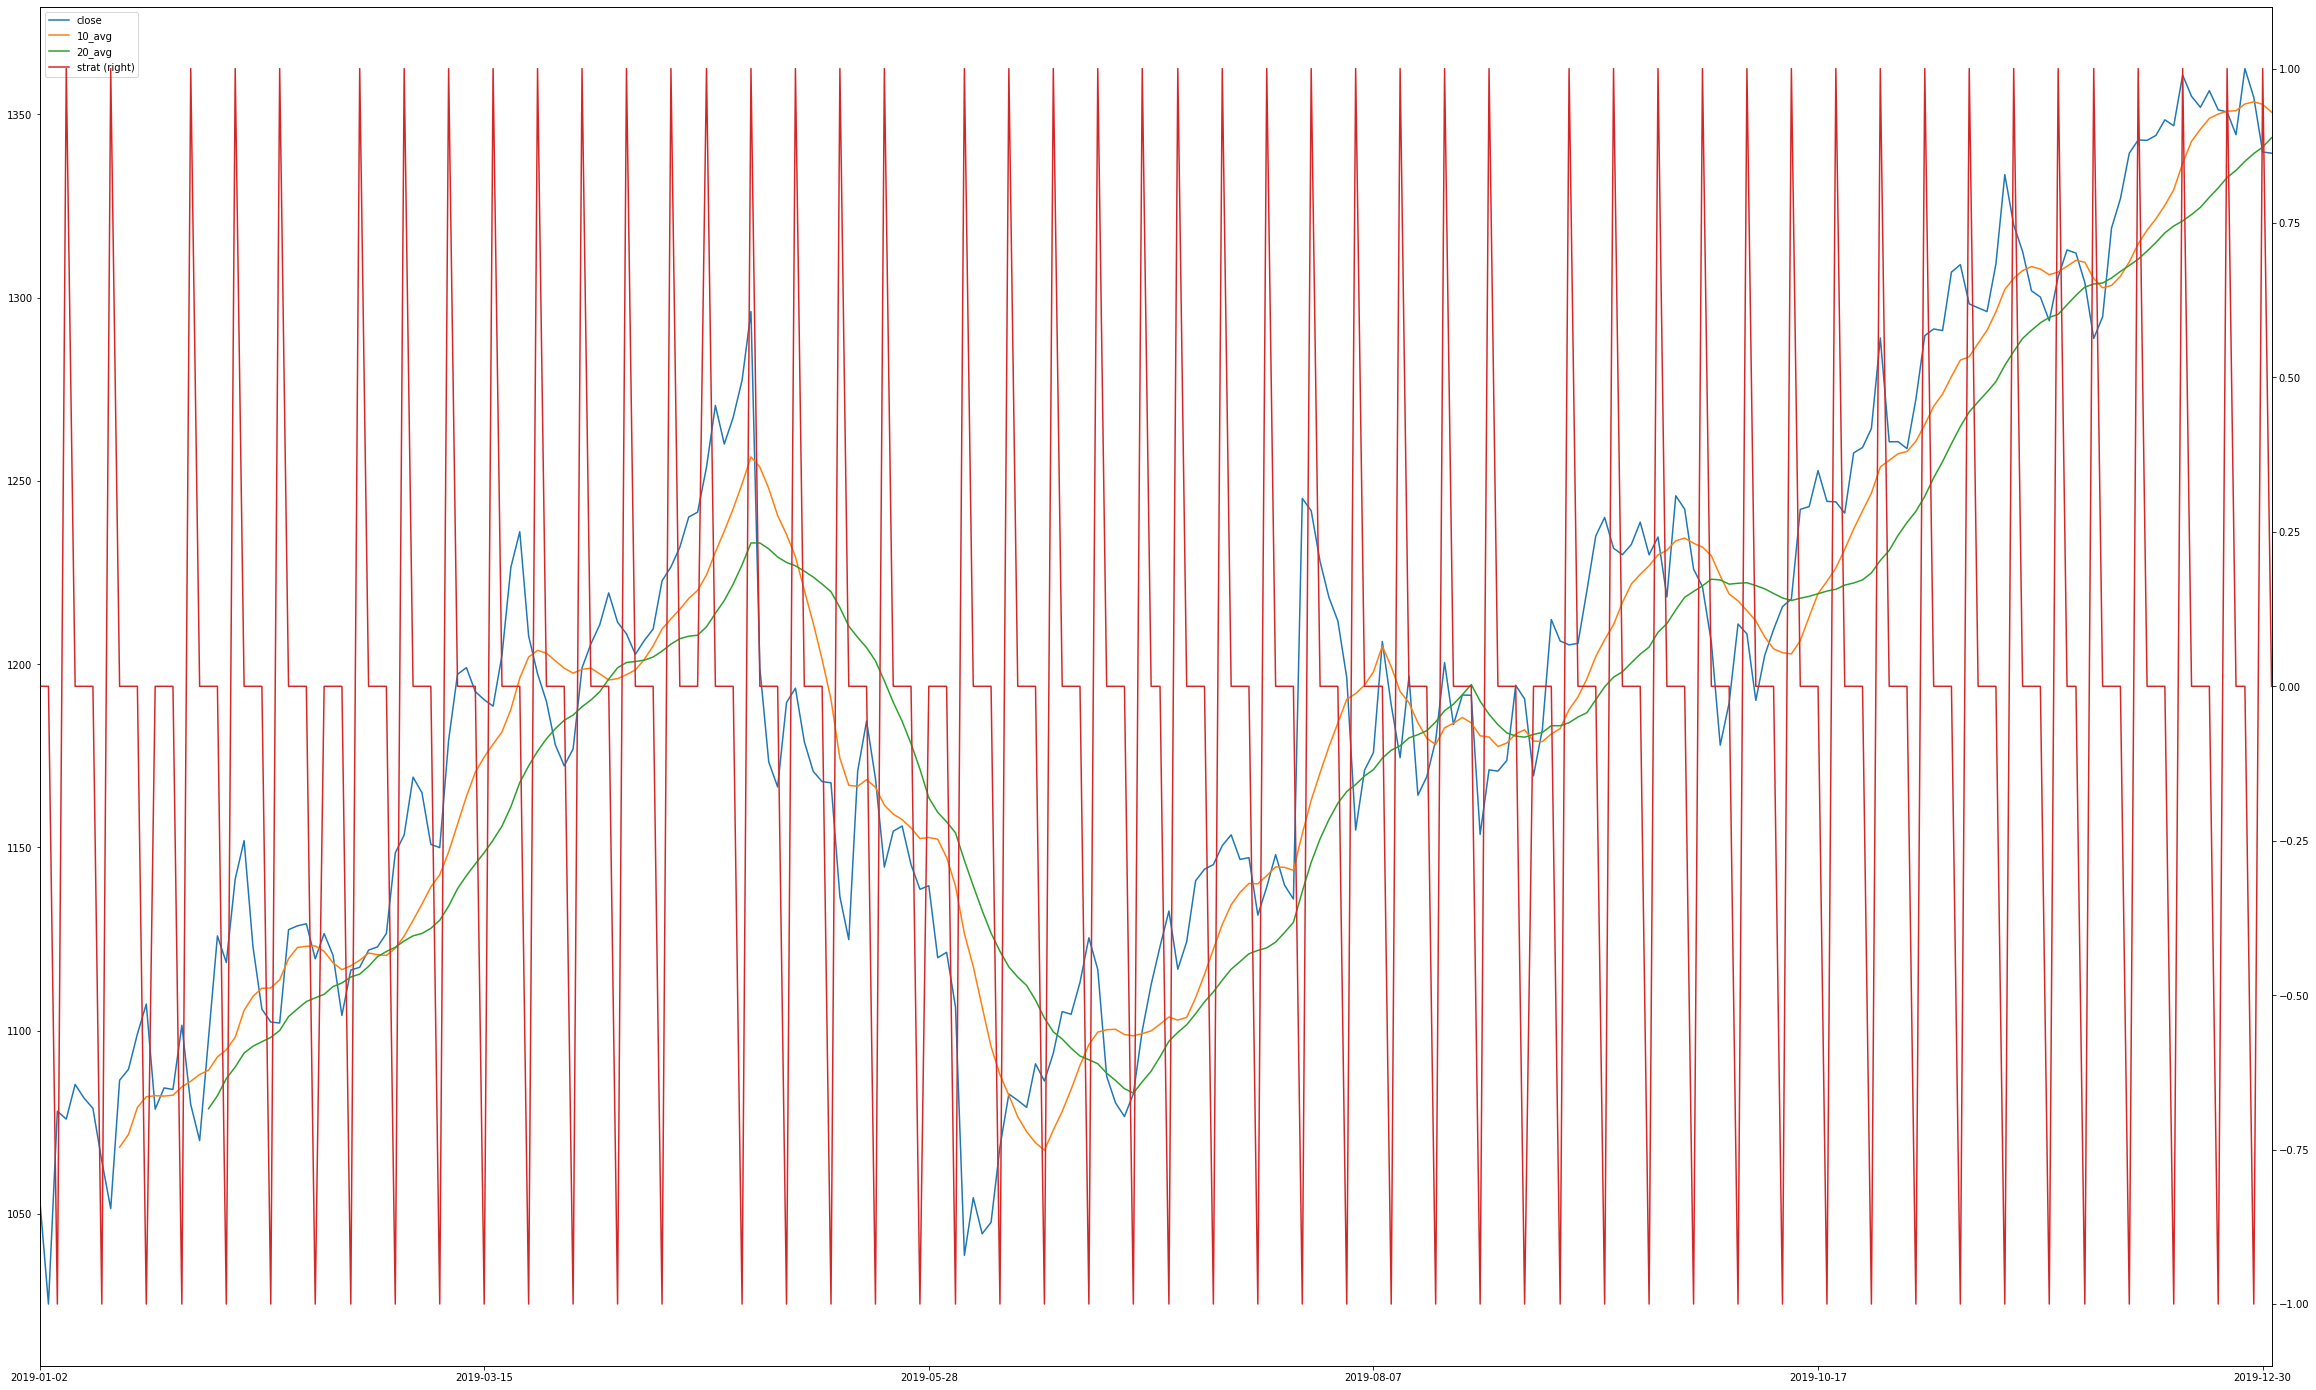

In [134]:
MKT_BOOK['GOOGL'][['close', '10_avg', '20_avg', 'strat']].plot(figsize=(40,25), secondary_y='strat')

In [135]:
def plot_strat(sym):    
    strat_plot = pd.DataFrame([MKT_BOOK[sym]['strat_returns'], MKT_BOOK[sym]['passive_returns']])
    strat_plot = strat_plot.transpose()
    strat_plot.plot(figsize=(20,12))

In [136]:
INITIAL_BET = 10000 # USD 10000 per security
PORTFOLIO_PROFIT = 0
STARTING_CAPITAL = len(SYM_LIST * INITIAL_BET) # Equal weighted investment in universe securities
returns = []
for sym in SYM_LIST:
    PORTFOLIO_PROFIT += ((MKT_BOOK[sym][-1:]['strat_returns'] + 1) * INITIAL_BET) - INITIAL_BET # etc.
print("Returns Per Instrument\n=================================")
for sym in SYM_LIST:
    print("{} : {}".format(sym, (MKT_BOOK[sym][-1:]['strat_returns'].to_string(index=False))))
print("Starting Capital: {}".format(STARTING_CAPITAL))
print("Profit/Loss: {}".format(PORTFOLIO_PROFIT))
print("P/L %: {}".format((STARTING_CAPITAL + PORTFOLIO_PROFIT) / STARTING_CAPITAL - 1))

Returns Per Instrument
GOOGL : 0.10
FB : 0.17
TWTR : 0.04
VRSN : 0.26
AKAM : 0.25
TRIP : 0.29
MSFT : 0.08
ADP : 0.15
CTXS : 0.07
IRM : -0.14
FFIV : -0.09
JPM : 0.05
BAC : 0.02
WFC : 0.01
C : 0.00
PNC : -0.01
CMA : 0.12
PYPL : 0.17
MA : 0.10
V : 0.13
AXP : 0.16
COF : 0.07
DFS : 0.11
SYF : 0.07
EFX : 0.14
WU : 0.16
NAVI : 0.04
ORCL : 0.01
ADBE : 0.17
CRM : 0.26
INTU : 0.19
ANSS : 0.12
CDNS : 0.17
WMT : 0.03
COST : 0.11
TGT : -0.01
DG : 0.10
DLTR : -0.19
DIS : 0.07
CMCSA : 0.32
FOXA : -0.02
Starting Capital: 410000
Profit/Loss: 2019-12-31   38,493.42
Name: strat_returns, dtype: float64
P/L %: 2019-12-31   0.09
Name: strat_returns, dtype: float64


In [137]:
# Consider regime switching for what strat to run

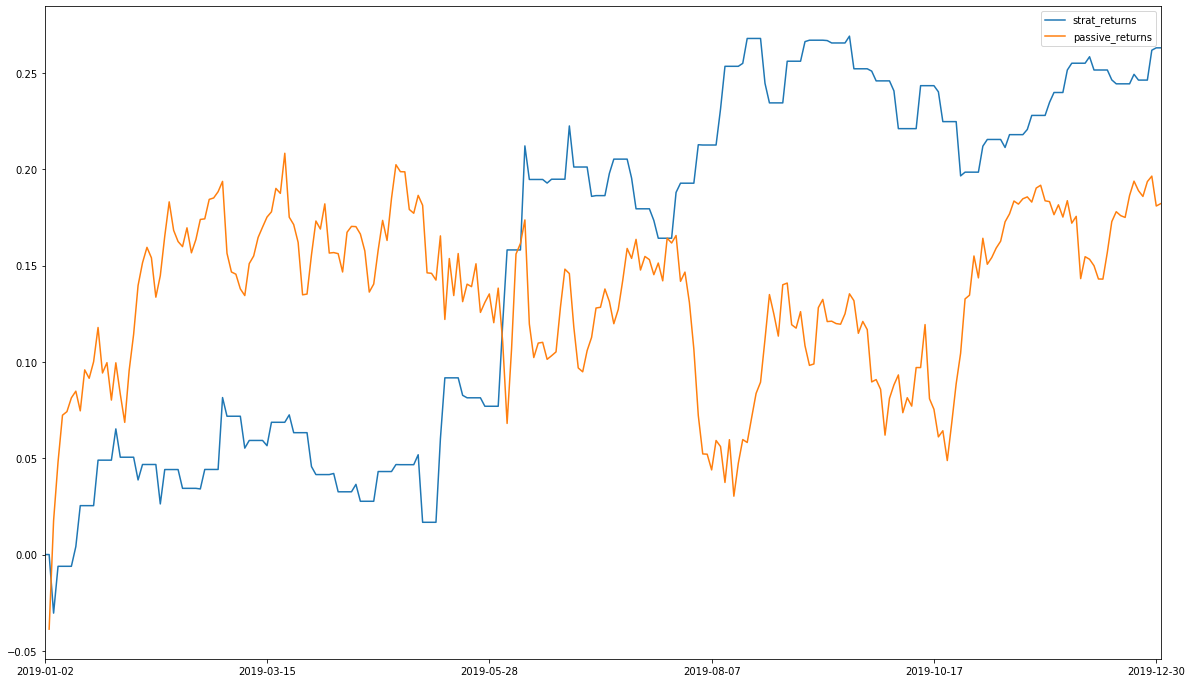

In [140]:
plot_strat('CRM')

In [ ]:
# Learn how to group volume by day.
# What's emerging is a vector of variables.

In [ ]:
# Strat to implement - buy at close, sell at open
# Strat to implement - more than one std_dev above regression line

In [ ]:
'''
Work to implement - split universe to quantiles by returns, volume, std_dev from mean? etc.
See Example 2 at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.quantile.html
''' 